In [1]:
import sys
sys.path.insert(0, '/home/workspace/mm_analysis')
sys.path.insert(0, '/home/workspace/')

from py_util import *
from utilities import *

hdir = '/home/workspace'
wdir = hdir + "/mm_analysis/EXP-01244"
pltdir = wdir + "/plots/"
objdir = wdir + "/objects/"
degdir = wdir + "/deg_list/"

In [91]:
from scipy.stats import median_abs_deviation

def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (np.median(M) + nmads * median_abs_deviation(M) < M)
    
    return outlier


def process_h5s(cr_outs_path):

    # Dictionary mapping user-friendly sample names to their corresponding IDs
    sample_dict = {
       'week2': "OR07965-01",     # Maps time point labels to sample IDs
       'week3': "OR07965-02", 
       'week4': "OR00001",
       'bm': "BMC07965-007",      # Bone marrow sample
       'msc': "CELL00911"         # Mesenchymal stem cell sample
    }

    name_dict = {
       'week2': "Week 2",
       'week3': "Week 3", 
       'week4': "Week 4",
       'bm': "BMMC Start Sample",
       'msc': "MSC Start Sample"   
    }
    
    # Create reverse mapping from sample IDs to their user-friendly names
    id_to_sample = {v: k for k, v in sample_dict.items()}
    
    # Find all filtered_feature_bc_matrix.h5 files in the directory structure
    h5_paths = [os.path.join(root, 'sample_filtered_feature_bc_matrix.h5') 
               for root, _, files in os.walk(cr_outs_path) 
               if 'sample_filtered_feature_bc_matrix.h5' in files]
    
    # Dictionary to store AnnData objects for each sample
    adatas = {}
    
    # Process each H5 file
    for path in h5_paths:
        # Extract sample name from path (e.g., 'BMC07965-007_3')
        name = path.split('per_sample_outs/')[1].split('/')[0]
        
        # Read the H5 file and create AnnData object
        adata = sc.read_10x_h5(path)
        adata.var_names_make_unique()
        adatas[name] = adata
        
        # Run Scrublet for doublet detection
        scrub = scrublet.Scrublet(adata.X)
        doublet_scores, predicted_doublets = scrub.scrub_doublets(verbose=False)

        # Add Scrublet results to cell metadata
        adata.obs['doublet_score'] = doublet_scores
        adata.obs['predicted_doublet'] = predicted_doublets

    # Combine all samples into one AnnData object
    concat = ad.concat(adatas, label='sample', join='outer', merge='same')

    concat.obs['base_sample'] = concat.obs['sample'].str.replace(r'_\d+$', '', regex=True)      # Add metadata column for batched replicates
    concat.obs['sample_type'] = concat.obs['base_sample'].replace(id_to_sample)                 # Add sample names (week2, week3, etc.)
    concat.obs['name'] = concat.obs['sample_type'].replace(name_dict)                           # Add pretty names (Week 2, Week 3, etc.)

    return concat


def process_groups(file_path):

    adata = process_h5s(file_path)
    
    adata.var["mt"] = adata.var_names.str.startswith("MT-")                 # mitochondrial genes
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))      # ribosomal genes
    adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))           # hemoglobin genes

    sc.pp.calculate_qc_metrics(
        adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
    )
    
    adata.obs["outlier"] = (
        is_outlier(adata, "log1p_total_counts", 5)
        | is_outlier(adata, "log1p_n_genes_by_counts", 5)
        | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
    )
    
    adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
        adata.obs["pct_counts_mt"] > 8
    )
    
    print(f"Total number of cells: {adata.n_obs}")
    adata = adata[adata.obs["predicted_doublet"] == False].copy()
    adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()
    
    print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")
    
    # Store raw counts
    adata.layers["counts"] = adata.X.copy()
    
    # Normalizing to median total counts
    sc.pp.normalize_total(adata)
    
    # Logarithmize the data
    sc.pp.log1p(adata)
    
    # Identify highly variable genes
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.25)

    # Save raw
    adata.raw = adata
    adata = adata[:, adata.var_names[adata.var['highly_variable']]].copy()
    
    # Scale the data
    sc.pp.scale(adata, max_value=10, zero_center=False)
    
    # Perform PCA
    sc.tl.pca(adata, svd_solver='arpack')
    adata.obsm['X_pca_temp'] = adata.obsm['X_pca']

    # Harmonizing data based on sample type
    X = adata.obsm['X_pca'].astype(np.float64)
    harmony_out = hm.run_harmony(X, adata.obs, 'sample_type')
    adata.obsm['X_pca'] = harmony_out.Z_corr.T

    # Compute neighbors and UMAP
    sc.pp.neighbors(adata, n_neighbors=50, use_rep='X_pca', n_pcs=20)
    sc.tl.umap(adata, min_dist=0.45, random_state=0, n_components=2)

    # Computing a range of leiden resolutions from 0-2 in increments of 0.2
    res_range = np.round(np.arange(0, 2.2, 0.2), 1)
    for res in res_range:
        sc.tl.leiden(
            adata, 
            flavor="igraph",
            key_added=f"leiden_{str(res).replace('.', '_')}",
            n_iterations=2,
            resolution=res
        )
    
    # sc.tl.rank_genes_groups(adata, 'leiden', method='t-test', key_added = "t-test")
    
    return adata

In [3]:
cr_outs_path = os.path.join(hdir, "mm_analysis/EXP-01244/cr_data/EXP-01244_cr_outs")

raw_adata = process_h5s(cr_outs_path)
# adata = process_groups(cr_outs_path)

raw_adata.write(wdir + '/rerun_objects/raw_adata.h5ad', compression='gzip')
# adata.write(wdir + '/rerun_objects/adata.h5ad', compression='gzip')

... storing 'base_sample' as categorical
... storing 'sample_type' as categorical
... storing 'name' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


# Cell Quality Control

- Visualize all cells, and color by which would be removed and why?

In [64]:
# help(sns.histplot)
raw_adata.obs

,doublet_score,predicted_doublet,sample,base_sample,sample_type,name,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb
AAACCAATCCAGAACGAAGTAGAG-1,0.062954,False,OR00001_3,OR00001,week4,Week 4,2444,7.801800,6530.0,8.784315,19.448698,0.0,0.000000,0.000000,0.0,0.0,0.0,6.0,1.945910,0.091884
AAACCAATCGTCCCGAAAGTAGAG-1,0.038835,False,OR00001_3,OR00001,week4,Week 4,867,6.766192,1221.0,7.108244,14.742015,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
AAACCAGGTACCTTAAAAGTAGAG-1,0.259494,False,OR00001_3,OR00001,week4,Week 4,1251,7.132498,1924.0,7.562681,15.904366,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
AAACCAGGTGACACAAAAGTAGAG-1,0.031390,False,OR00001_3,OR00001,week4,Week 4,400,5.993961,510.0,6.236370,17.450980,11.0,2.484907,2.156863,0.0,0.0,0.0,0.0,0.000000,0.000000
AAACCAGGTTAACGAGAAGTAGAG-1,0.045738,False,OR00001_3,OR00001,week4,Week 4,760,6.634633,1180.0,7.074117,19.322034,1.0,0.693147,0.084746,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGAGTAGGTTTCAACGGGAA-1,0.038341,False,OR07965-01_2,OR07965-01,week2,Week 2,1485,7.303843,3414.0,8.135933,39.045108,2.0,1.098612,0.058582,0.0,0.0,0.0,1.0,0.693147,0.029291
TTTGTGAGTATGGTGAAACGGGAA-1,0.037313,False,OR07965-01_2,OR07965-01,week2,Week 2,3360,8.119994,7728.0,8.952735,11.425983,9.0,2.302585,0.116460,0.0,0.0,0.0,1.0,0.693147,0.012940
TTTGTGAGTTCATTGAAACGGGAA-1,0.120930,False,OR07965-01_2,OR07965-01,week2,Week 2,7573,8.932477,83019.0,11.326837,28.682591,9.0,2.302585,0.010841,0.0,0.0,0.0,40.0,3.713572,0.048182
TTTGTGAGTTCTCAAAAACGGGAA-1,0.063091,False,OR07965-01_2,OR07965-01,week2,Week 2,859,6.756932,1444.0,7.275865,21.952909,2.0,1.098612,0.138504,0.0,0.0,0.0,0.0,0.000000,0.000000


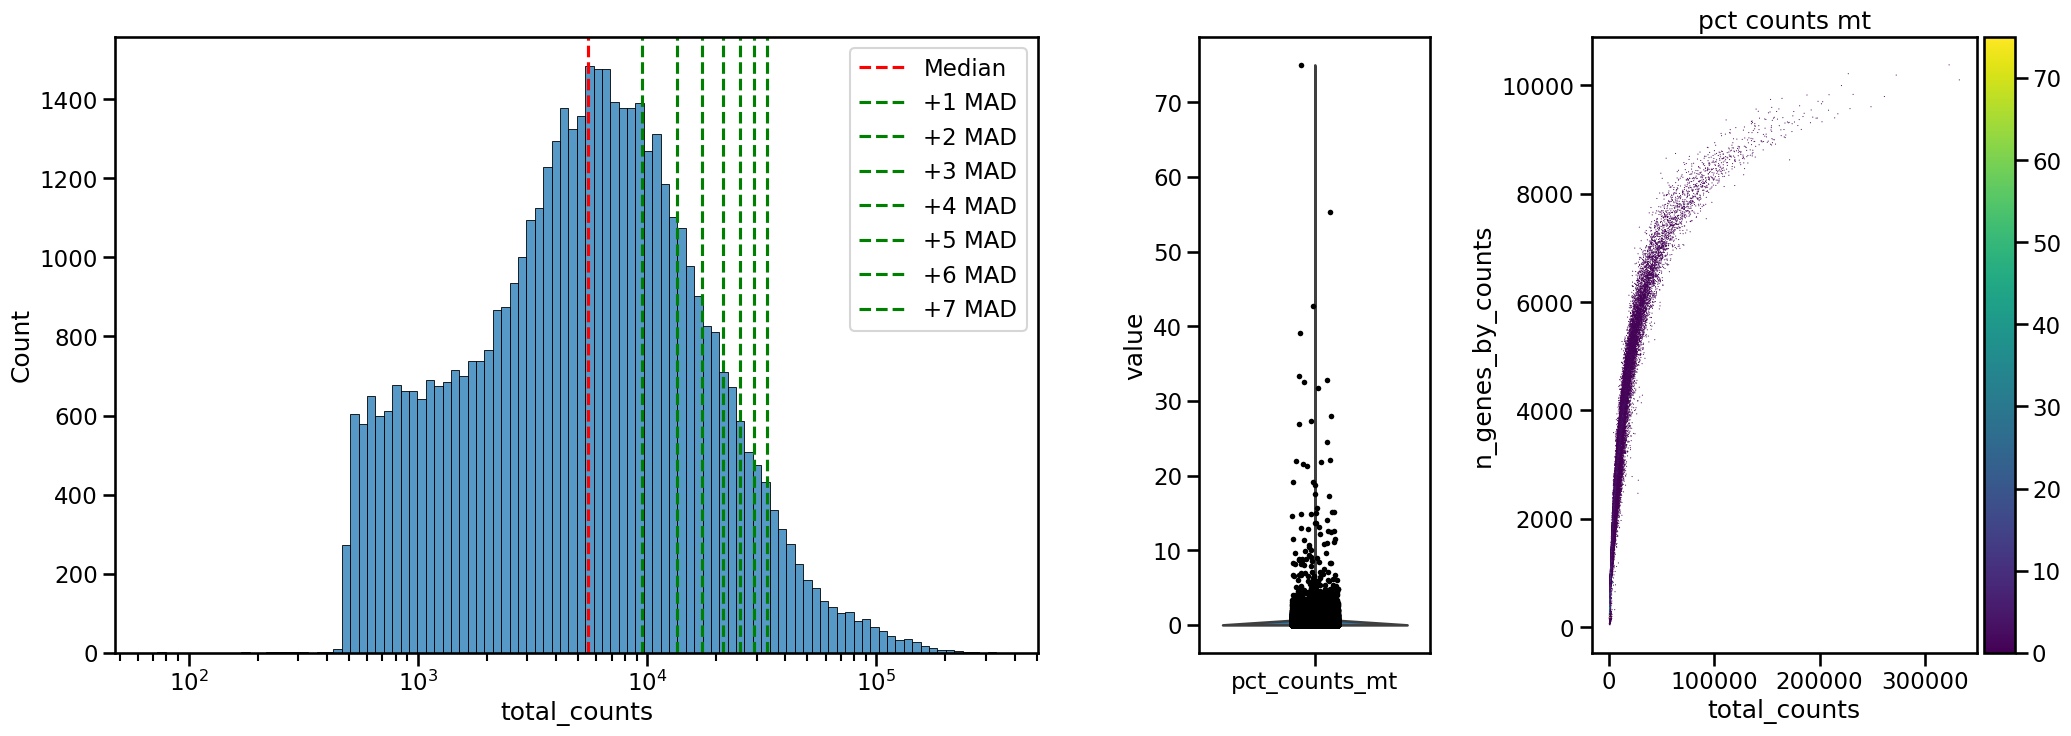

Median: 5540.00
MAD: 3959.00
Upper bound (range(1, 8) MADs): 33253.00


In [90]:
import numpy as np
from scipy.stats import median_abs_deviation
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc

def plot_with_mads(adata, nmads=range(1, 8)):
    fig, ax = plt.subplots(1, 3, figsize=(25, 8), 
                          gridspec_kw={'width_ratios': [2, 0.5, 1], 'wspace': 0.3})
    
    # Calculate MAD thresholds
    M = adata.obs["total_counts"]
    median = np.median(M)
    mad = median_abs_deviation(M)
    
    # Plot histogram with MAD thresholds
    sns.histplot(
        data=M,
        bins=100,
        kde=False,
        ax=ax[0],
        log_scale=True
    )
    
    # Add vertical lines for median and MAD thresholds
    ax[0].axvline(x=median, color='red', linestyle='--', label='Median')

    for nmad in nmads:
        upper_bound = median + nmad * mad
        ax[0].axvline(x=upper_bound, color='green', linestyle='--', label=f'+{nmad} MAD')

    ax[0].legend()
    
    # Violin plot
    sc.pl.violin(
        adata,
        "pct_counts_mt",
        show=False,
        ax=ax[1],
        size=4
    )
    
    # Scatter plot
    scatter = sc.pl.scatter(
        adata,
        "total_counts",
        "n_genes_by_counts",
        color="pct_counts_mt",
        show=False,
        ax=ax[2]
    )
    
    # Clear existing colorbar and add new one
    ax[2].collections[0].colorbar.remove()
    plt.colorbar(ax[2].collections[0], ax=ax[2], pad=0.015)
    
    plt.show()
    
    # Print the threshold values
    print(f"Median: {median:.2f}")
    print(f"MAD: {mad:.2f}")
    print(f"Upper bound ({nmads} MADs): {upper_bound:.2f}")

# Usage:
plot_with_mads(raw_adata)

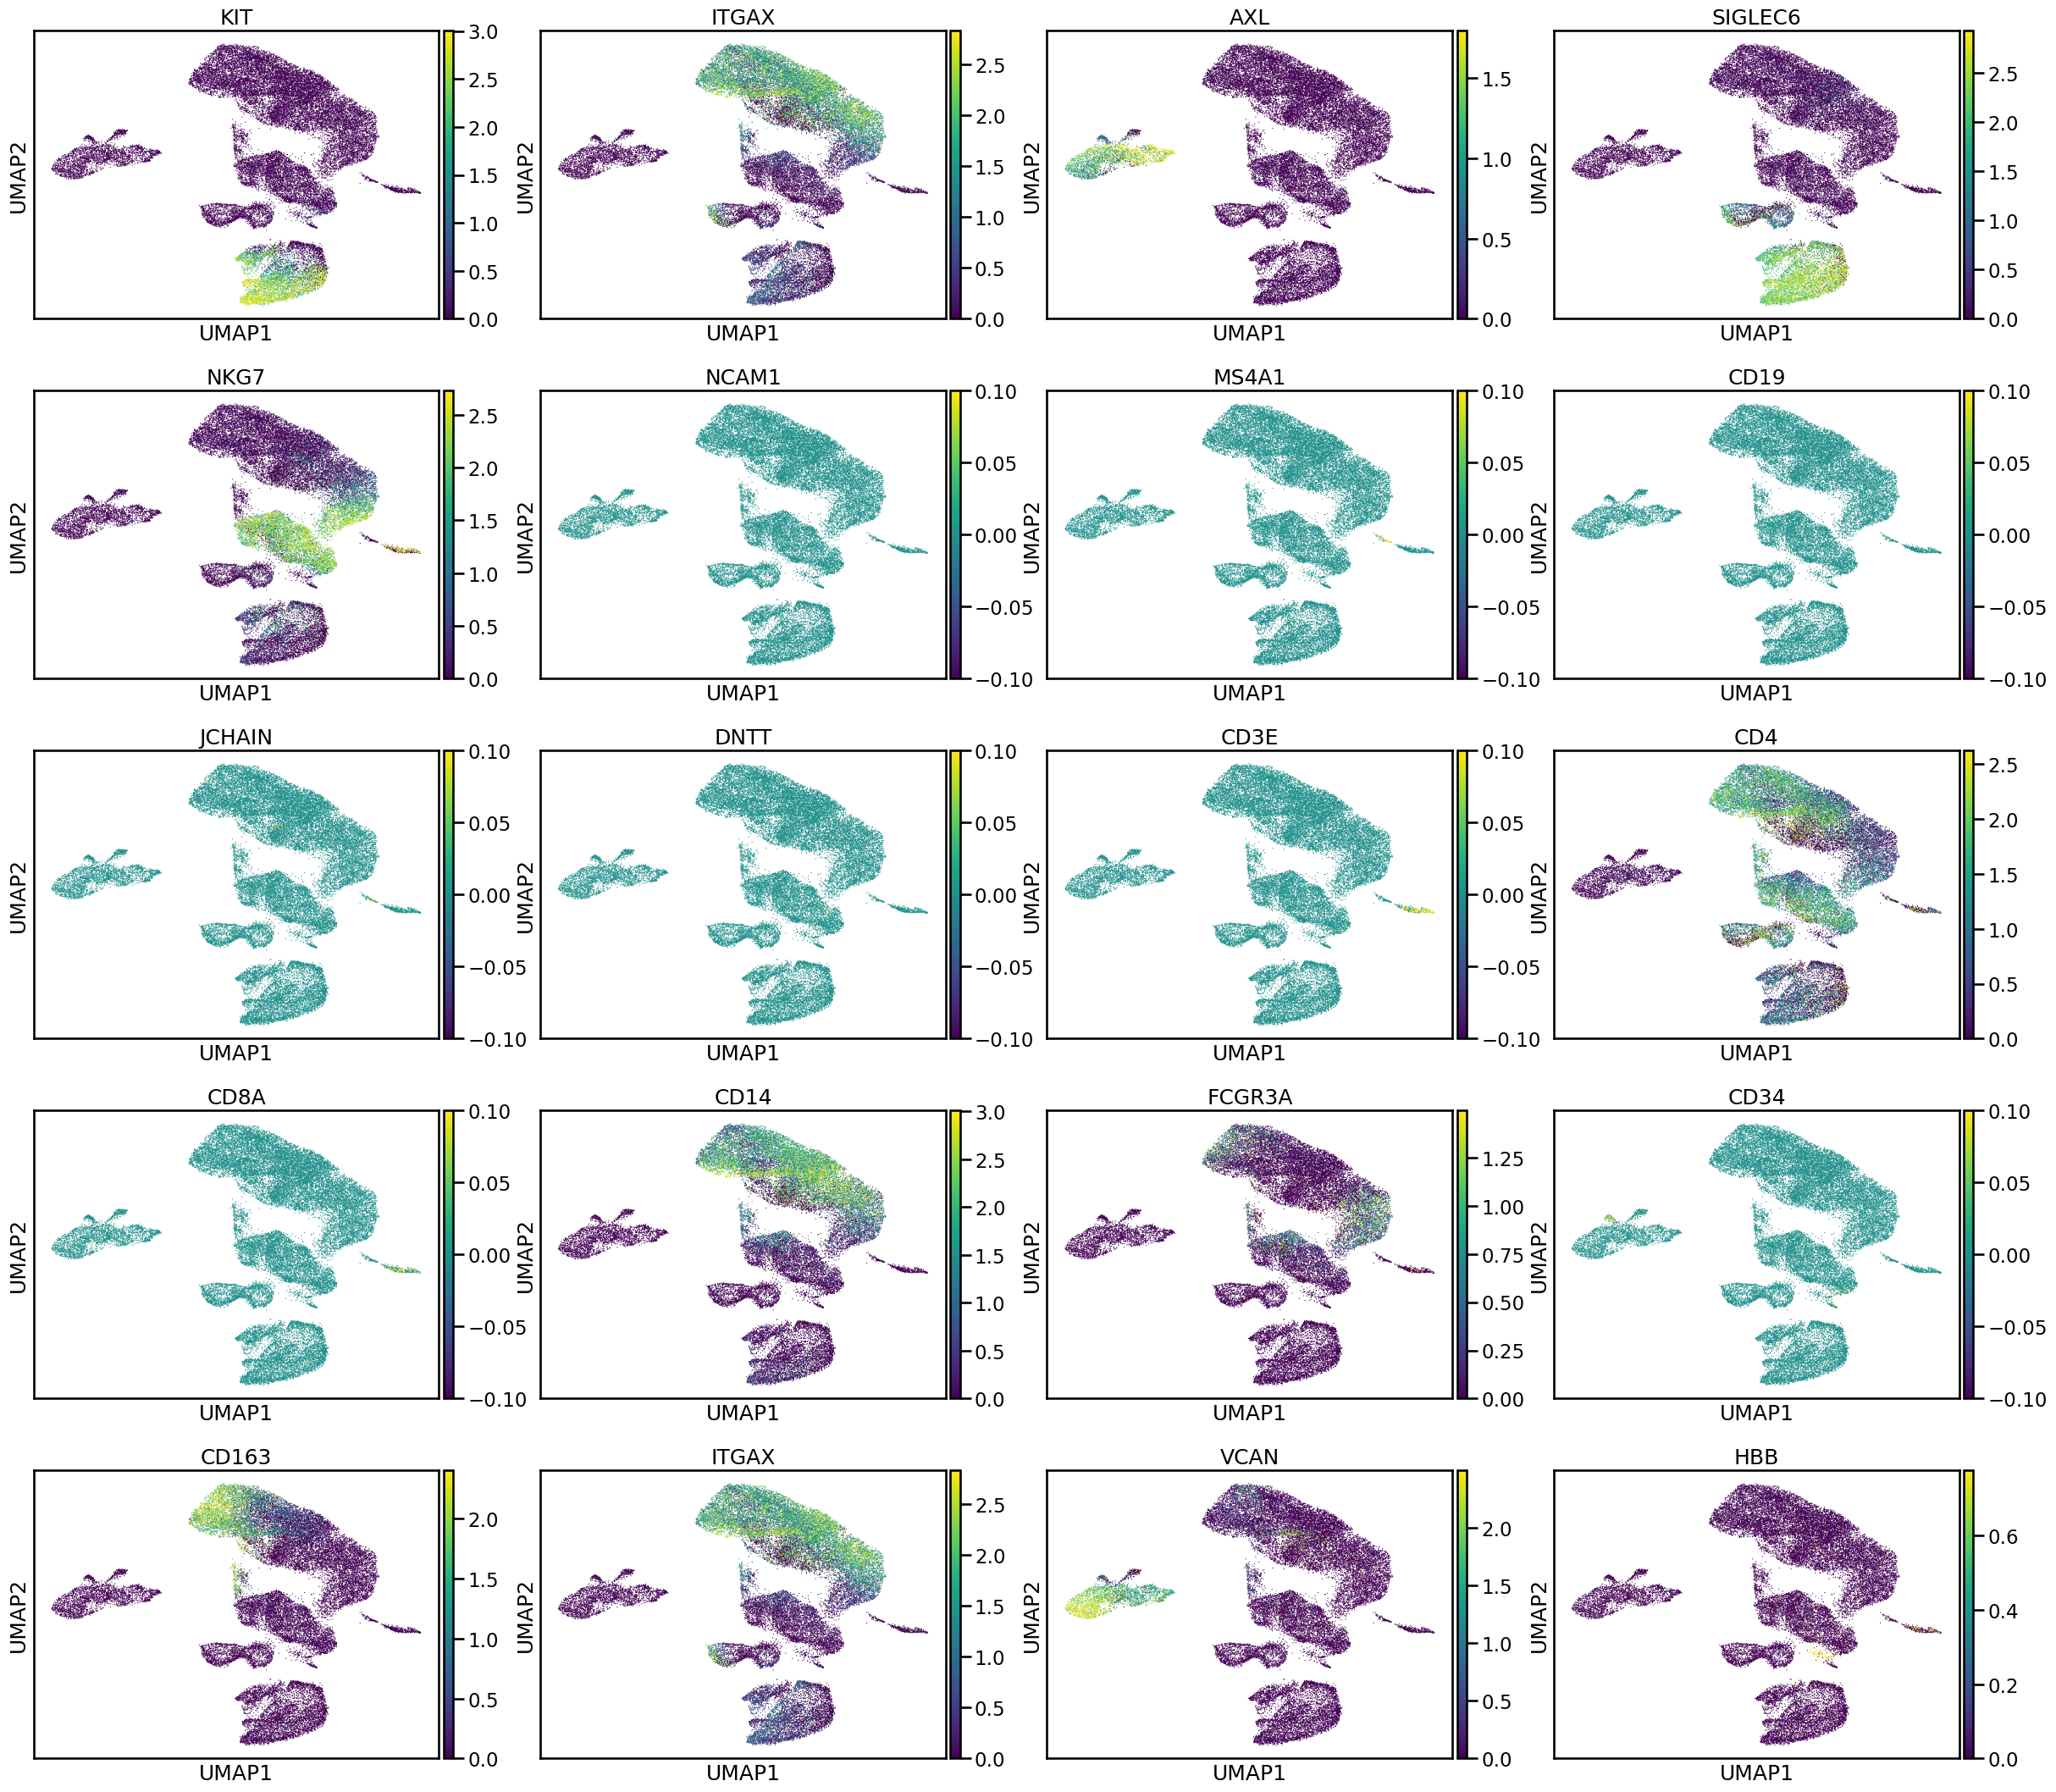

In [71]:
markers = ['KIT', 'ITGAX', 'AXL', 'SIGLEC6', 'NKG7', 'NCAM1', 'MS4A1', 'CD19', 'JCHAIN', 'DNTT', 'CD3E', 'CD4', 'CD8A', 'CD14', 'FCGR3A', 'CD34',  'CD163', 'ITGAX', 'VCAN', 'HBB']

sc.pl.umap(
    adata,
    size=3,
    color=markers,
    vmax='p99'
)

In [60]:
types = adata.obs['sample_type']

stats = {
    sample: len(adata[types == sample])
    for sample in list(types.unique())
}

print(stats)

print(adata.obs)

{'week4': 9227, 'week2': 19306, 'bm': 1036, 'week3': 952, 'msc': 2324}
                            doublet_score  predicted_doublet        sample  \
AAACCAATCCAGAACGAAGTAGAG-1       0.062954              False     OR00001_3   
AAACCAATCGTCCCGAAAGTAGAG-1       0.038835              False     OR00001_3   
AAACCAGGTACCTTAAAAGTAGAG-1       0.259494              False     OR00001_3   
AAACCAGGTTAACGAGAAGTAGAG-1       0.045738              False     OR00001_3   
AAACCGGTCTTAAGCTAAGTAGAG-1       0.047619              False     OR00001_3   
...                                   ...                ...           ...   
TTTGTGAGTAGGTTTCAACGGGAA-1       0.038341              False  OR07965-01_2   
TTTGTGAGTATGGTGAAACGGGAA-1       0.037313              False  OR07965-01_2   
TTTGTGAGTTCATTGAAACGGGAA-1       0.120930              False  OR07965-01_2   
TTTGTGAGTTCTCAAAAACGGGAA-1       0.063091              False  OR07965-01_2   
TTTGTGAGTTTAACCAAACGGGAA-1       0.040462              False  OR07965-0